In [260]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [185]:
#http://delivery.acm.org/10.1145/2920000/2915249/p679-ding.pdf?ip=128.12.253.7&id=2915249&acc=ACTIVE%20SERVICE&key=AA86BE8B6928DDC7%2E0AF80552DEC4BA76%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1573589891_b0c574a07410dd1758521659df32f759
#pg 682
#handles large datasets only
def sample_and_seek (Q, e, data):
    F = Q[1]
    result = []
    if (F == 'COUNT'):
        T_0 = uniform_sample (e, data)
        result = ProcessWithDataBubble (Q, T_0)
    elif (F == 'SUM'):
        T_M = measure_biased_sample (e, data)
        result = ProcessWithDataBubble (Q, T_M)
    x = result[0]   
    sup_x = result[1]
    if (sup_x >= (1/(e**2))):
        return [val for val in x.values()]
    else:
        print ("Warning: Cannot gauruntee approximate query within error bounds: predicative selectivity too small")

In [186]:
def uniform_sample (e, data):
    n = len(data[0])
    nrow = int(math.sqrt(n)/(e**2))
    sample_indices = np.random.choice(len(data[0]), nrow, True)
    sample_table = np.zeros (shape=(len(sample_indices), len(data))).tolist()
    for i in range (len(sample_indices)):
        for c in range (len(data)):
            sample_table [i][c] = data[c][sample_indices[i]]
    return sample_table

In [187]:
def measure_biased_sample (e, data):
    n = len(data[0])
    nrow = int(math.sqrt(n)/(e**2))
    sample_probabilities = []
    for i in range (len(data[0])):
        sample_probabilities.append (data[0][i])
    sample_probabilities = sample_probabilities/np.sum(sample_probabilities)
    sample_indices = np.random.choice(len(data[0]), nrow, True, sample_probabilities)
    sample_table = np.zeros (shape=(len(sample_indices), len(data))).tolist()
    for i in range (len(sample_indices)):
        for c in range (len(data)):
            sample_table [i] [c] = data[c][sample_indices[i]]
    return sample_table

In [188]:
#returns a distribution estimate for the query Q
def ProcessWithDataBubble (Q, T_prime):
    P = Q[2]
    x = {}
    sup_x = 0
    for row in range (len(T_prime)):
        i = T_prime[row][1]
        if (i not in x):
            x[i] = 1
        else:  
            x[i] += 1
        if (i == P):
            sup_x += 1
    sum_vals = sum(x.values())
    for key in x.keys():
        x[key]/=sum_vals
    return [x, sup_x]

In [269]:
#test on one example
price_data = abs(np.random.normal(loc = 0, scale = 10000, size=1000000))
predicate_data = np.random.choice(['Coke', 'Pepsi'], 1000000, True)
data = [price_data, predicate_data]
e = .1
Q = (None, 'SUM', 'Coke')
proportions_estimate = sample_and_seek (Q, e, data)

In [270]:
#get actual proportions
actual_proportions = {}
for row in range (len(data[0])):
    i = data[1][row]
    if (i not in actual_proportions):
        actual_proportions[i] = 1
    else:  
        actual_proportions[i] += 1
sum_vals = sum(actual_proportions.values())
for key in actual_proportions.keys():
    actual_proportions[key]/=sum_vals
actual_proportions_vals = [val for val in actual_proportions.values()]

In [271]:
actual_proportions

{'Coke': 0.49941, 'Pepsi': 0.50059}

In [203]:
#calculate L_2 distance
L_2_distance = 0
for i in range (len(actual_proportions_vals)):
    L_2_distance += (actual_proportions_vals[i]-proportions_estimate[i])**2
L_2_distance = math.sqrt(L_2_distance)

In [350]:
#creates a mixed sample of size budget with proportion_uniform uniform samples and 1-proportion_uniform measure
#biased sample
def mixed_sample (data, budget, proportion_uniform):
    proportion_measure_biased = 1-proportion_uniform
    nrow_uniform = int(budget*proportion_uniform)
    nrow_measure_biased = int(budget*proportion_measure_biased)
    #create uniform sample
    sample_indices_uniform = np.random.choice(len(data[0]), nrow_uniform, True)
    sample_table_uniform = np.zeros (shape=(len(sample_indices_uniform), len(data))).tolist()
    
    sum_uniform = 0
    num_uniform = 0
    for i in range (len(sample_indices_uniform)):
        for c in range (len(data)):
            sample_table_uniform [i][c] = data[c][sample_indices_uniform[i]]
            
        sum_uniform += data[0][sample_indices_uniform[i]]
        num_uniform += 1
    
    #create measure biased sample
    sample_probabilities = []
    for i in range (len(data[0])):
        sample_probabilities.append (data[0][i])
    sample_probabilities = sample_probabilities/np.sum(sample_probabilities)
    sample_indices_measure_biased = np.random.choice(len(data[0]), nrow_measure_biased, True, sample_probabilities)
    sample_table_measure_biased = np.zeros (shape=(len(sample_indices_measure_biased), len(data))).tolist()
    sum_measure_biased=0
    num_measure_biased=0
    for i in range (len(sample_table_measure_biased)):
        for c in range (len(data)):
            sample_table_measure_biased [i] [c] = data[c][sample_indices_measure_biased[i]]
        sum_measure_biased+=data[0][sample_indices_measure_biased[i]]
        num_measure_biased += 1
    #merge tables
    merged_table = sample_table_uniform + sample_table_measure_biased
    #sanity check
    #print ("Avg uniform: " + str (sum_uniform/num_uniform))
    #print ("Avg measure biased: " + str (sum_measure_biased/num_measure_biased))
    return merged_table

In [351]:
#Test different mix ratios on different budgets
#set up params
price_data = abs(np.random.normal(loc = 0, scale = 1000, size=20000))
predicate_data = np.random.choice(['Coke', 'Pepsi'], 20000, True)
data = [price_data, predicate_data]
Q = (None, 'SUM', 'Coke')
e = .1
n = len(data[0])
budgets = [n**.5, n**.6, n**.7, n**.8, n**.9]
proportion_uniforms = list(range(0,101))
for i in range (len(proportion_uniforms)):
    proportion_uniforms[i]/=100

In [352]:
#get actual proportions
actual_proportions = {}
for row in range (len(data[0])):
    i = data[1][row]
    if (i not in actual_proportions):
        actual_proportions[i] = 1
    else:  
        actual_proportions[i] += 1
sum_vals = sum(actual_proportions.values())
for key in actual_proportions.keys():
    actual_proportions[key]/=sum_vals
actual_proportions_vals = [val for val in actual_proportions.values()]

******* NEW EXAMPLE *******
data size: 20000
budget size: 141


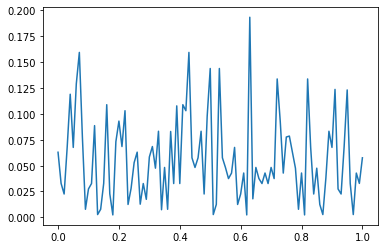

******* NEW EXAMPLE *******
data size: 20000
budget size: 380


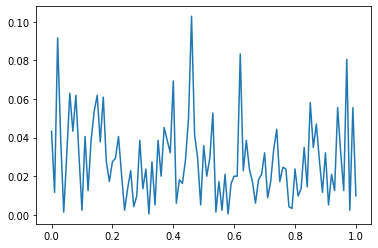

******* NEW EXAMPLE *******
data size: 20000
budget size: 1024


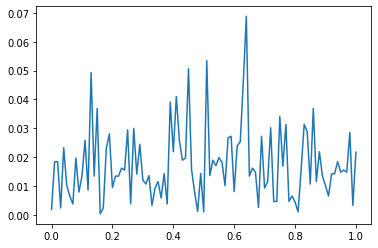

******* NEW EXAMPLE *******
data size: 20000
budget size: 2759


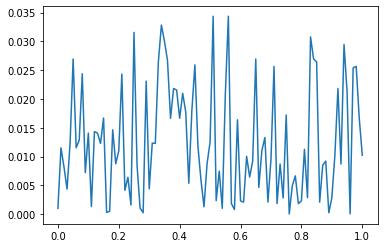

******* NEW EXAMPLE *******
data size: 20000
budget size: 7428


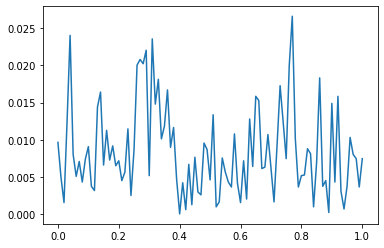

In [353]:
#plot evaluation
for i in range (len(budgets)):
    budget = budgets[i]
    errors = []
    for j in range (len(proportion_uniforms)):
        proportion_uniform = proportion_uniforms[j]
        T_mixed = mixed_sample(data, budget, proportion_uniform)
        #print (budget)
        #print (proportion_uniform)
        #print (T_mixed)
        result = ProcessWithDataBubble (Q, T_mixed)
        x = result[0]   
        proportions_estimate = [val for val in x.values()]
        #eval error
        L_2_distance = 0
        for i in range (len(actual_proportions_vals)):
            L_2_distance += (actual_proportions_vals[i]-proportions_estimate[i])**2
        L_2_distance = math.sqrt(L_2_distance)
        errors.append(L_2_distance)
    print ("******* NEW EXAMPLE *******")
    print ("data size: " + str(len(data[0])))
    print ("budget size: " + str(int(budget)))
    plt.plot (proportion_uniforms, errors)
    plt.show()

Avg uniform: 842.3277777501565
Avg measure biased: 1288.1277226380787
